**# CELL 1: Setup & Imports**

In [1]:
import os
import shutil
import random
import json
from datetime import datetime
from collections import OrderedDict, Counter
import time

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader

# Set random seeds
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

print("✅ Libraries imported")
print(f"PyTorch: {torch.__version__}, CUDA: {torch.cuda.is_available()}")


✅ Libraries imported
PyTorch: 2.6.0+cu124, CUDA: False


**# CELL 2: Configuration & Helper Functions**

In [2]:
# Paths (Kaggle-specific)
working_base = '/kaggle/working/MobilePlantViT'
data_dir = os.path.join(working_base, 'data')
master_directory_path = os.path.join(data_dir, 'PlantVillage_Master')
split_directory_path = os.path.join(data_dir, 'PlantVillage_Split')

# Directories
train_dir = os.path.join(split_directory_path, 'train')
val_dir = os.path.join(split_directory_path, 'val')
test_dir = os.path.join(split_directory_path, 'test')

# Split ratios
SPLIT_RATIO = {'train': 0.70, 'val': 0.15, 'test': 0.15}

# ImageNet normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# DataLoader settings
BATCH_SIZE = 64
NUM_WORKERS = 4
PIN_MEMORY = True


def count_images_in_dir(directory):
    """Count total images and classes in a directory."""
    total_images = 0
    class_distribution = OrderedDict()
    
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            class_distribution[class_name] = len(images)
            total_images += len(images)
    
    return total_images, class_distribution

# Add to CELL 2 - after existing helper functions

def calculate_class_weights(class_distribution):
    """
    Calculate class weights for weighted loss.
    Uses inverse frequency weighting.
    """
    total_samples = sum(class_distribution.values())
    num_classes = len(class_distribution)
    
    class_weights = {}
    for class_name, count in class_distribution.items():
        # Inverse frequency weight
        weight = total_samples / (num_classes * count)
        class_weights[class_name] = weight
    
    return class_weights


def create_weighted_sampler(dataset, class_distribution):
    """
    Create WeightedRandomSampler for balanced batch sampling.
    """
    from torch.utils.data import WeightedRandomSampler
    
    # Calculate weights for each class
    class_weights = calculate_class_weights(class_distribution)
    
    # Assign weight to each sample based on its class
    sample_weights = []
    for img_path, class_idx in dataset.samples:
        class_name = dataset.classes[class_idx]
        sample_weights.append(class_weights[class_name])
    
    sample_weights = torch.DoubleTensor(sample_weights)
    
    # Create sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    return sampler

print("✅ Balancing helper functions added")

def print_section(title):
    """Print formatted section header."""
    print("\n" + "=" * 80)
    print(f"  {title}")
    print("=" * 80)


print("✅ Configuration set")



✅ Balancing helper functions added
✅ Configuration set


**# CELL 3: Dataset Discovery & Verification**

In [3]:
print_section("DATASET DISCOVERY")

# Find PlantVillage dataset in Kaggle input
possible_paths = [
    '/kaggle/input/plantvillage-dataset',
    '/kaggle/input/plant-village-dataset',
    '/kaggle/input/plantvillage'
]

dataset_input_path = None
for path in possible_paths:
    if os.path.exists(path):
        dataset_input_path = path
        break

if not dataset_input_path:
    for item in os.listdir('/kaggle/input'):
        if 'plant' in item.lower():
            dataset_input_path = os.path.join('/kaggle/input', item)
            break

# Find class directory (the one containing actual class folders)
def find_class_directory(base_path):
    for root, dirs, files in os.walk(base_path):
        if dirs and any('___' in d or 'leaf' in d.lower() for d in dirs):
            for dir_name in dirs[:2]:
                test_path = os.path.join(root, dir_name)
                if os.path.isdir(test_path):
                    test_files = os.listdir(test_path)
                    if any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in test_files):
                        return root
    return base_path

DATASET_PATH = find_class_directory(dataset_input_path)

# Count and display dataset info
total_images, class_distribution = count_images_in_dir(DATASET_PATH)
CLASS_NAMES = list(class_distribution.keys())
NUM_CLASSES = len(CLASS_NAMES)

print(f"✅ Dataset found at: {DATASET_PATH}")
print(f"   Classes: {NUM_CLASSES}")
print(f"   Total Images: {total_images:,}")
print(f"   Avg per Class: {total_images/NUM_CLASSES:.0f}")



  DATASET DISCOVERY
✅ Dataset found at: /kaggle/input/plantvillage-dataset/segmented
   Classes: 38
   Total Images: 54,306
   Avg per Class: 1429


**# CELL 4: Dataset Quality Verification**

In [4]:
print_section("DATASET QUALITY VERIFICATION")

def verify_image(image_path):
    """
    Verify if an image file is valid and not corrupted.
    Returns: (is_valid, error_message)
    """
    try:
        # Open and verify image
        with Image.open(image_path) as img:
            img.verify()  # Verify it's a valid image
        
        # Re-open for additional checks (verify() closes the file)
        with Image.open(image_path) as img:
            img.load()  # Actually load the image data
            
            # Check if image has valid dimensions
            if img.size[0] == 0 or img.size[1] == 0:
                return False, "Zero dimensions"
            
            # Check if image mode is valid
            if img.mode not in ['RGB', 'L', 'RGBA', 'P']:
                return False, f"Invalid mode: {img.mode}"
        
        return True, None
        
    except FileNotFoundError:
        return False, "File not found"
    except Image.UnidentifiedImageError:
        return False, "Unidentified image format"
    except OSError as e:
        return False, f"OS error: {str(e)}"
    except Exception as e:
        return False, f"Unexpected error: {str(e)}"


def scan_and_verify_dataset(dataset_path):
    """
    Scan entire dataset and verify all images.
    Returns: Dictionary with verification results
    """
    results = {
        'total_files': 0,
        'valid_images': 0,
        'corrupted_images': 0,
        'corrupted_files': [],
        'class_stats': {}
    }
    
    print("Scanning and verifying all images...")
    print("This may take a few minutes...\n")
    
    for class_name in tqdm(CLASS_NAMES, desc="Verifying classes"):
        class_path = os.path.join(dataset_path, class_name)
        
        if not os.path.isdir(class_path):
            continue
        
        # Initialize class stats
        results['class_stats'][class_name] = {
            'total': 0,
            'valid': 0,
            'corrupted': 0
        }
        
        # Get all image files
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
        
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            results['total_files'] += 1
            results['class_stats'][class_name]['total'] += 1
            
            # Verify image
            is_valid, error_msg = verify_image(img_path)
            
            if is_valid:
                results['valid_images'] += 1
                results['class_stats'][class_name]['valid'] += 1
            else:
                results['corrupted_images'] += 1
                results['class_stats'][class_name]['corrupted'] += 1
                results['corrupted_files'].append({
                    'path': img_path,
                    'class': class_name,
                    'filename': img_file,
                    'error': error_msg
                })
    
    return results


# Run verification
verification_results = scan_and_verify_dataset(DATASET_PATH)

# Display results
print("\n" + "=" * 80)
print("  VERIFICATION RESULTS")
print("=" * 80)

print(f"\n📊 Overall Statistics:")
print(f"   Total Files Scanned: {verification_results['total_files']:,}")
print(f"   ✅ Valid Images:     {verification_results['valid_images']:,} ({verification_results['valid_images']/verification_results['total_files']*100:.2f}%)")
print(f"   ❌ Corrupted Images: {verification_results['corrupted_images']:,} ({verification_results['corrupted_images']/verification_results['total_files']*100:.2f}%)")

# Show corrupted files if any
if verification_results['corrupted_images'] > 0:
    print(f"\n⚠️  WARNING: Found {verification_results['corrupted_images']} corrupted images!")
    print("\nCorrupted Files List:")
    print("-" * 80)
    
    for idx, corrupted in enumerate(verification_results['corrupted_files'][:10], 1):
        print(f"{idx}. Class: {corrupted['class']}")
        print(f"   File: {corrupted['filename']}")
        print(f"   Error: {corrupted['error']}")
        print(f"   Path: {corrupted['path']}")
        print()
    
    if len(verification_results['corrupted_files']) > 10:
        print(f"... and {len(verification_results['corrupted_files']) - 10} more corrupted files")
    
    # Save corrupted files list
    corrupted_log_path = os.path.join(working_base, 'corrupted_images_log.json')
    with open(corrupted_log_path, 'w') as f:
        json.dump(verification_results['corrupted_files'], f, indent=4)
    print(f"\n📝 Full corrupted files list saved to: {corrupted_log_path}")
    
    # Show classes with most corrupted images
    corrupted_by_class = [(cls, stats['corrupted']) 
                         for cls, stats in verification_results['class_stats'].items() 
                         if stats['corrupted'] > 0]
    
    if corrupted_by_class:
        corrupted_by_class.sort(key=lambda x: x[1], reverse=True)
        print(f"\n📉 Classes with Corrupted Images (Top 5):")
        for cls, count in corrupted_by_class[:5]:
            print(f"   {cls}: {count} corrupted")
    
    # Ask for action
    print("\n" + "=" * 80)
    print("⚠️  RECOMMENDED ACTIONS:")
    print("   1. Remove corrupted files before training")
    print("   2. Review the corrupted_images_log.json file")
    print("   3. Consider replacing corrupted images if possible")
    print("=" * 80)
    
else:
    print(f"\n✅ Great! No corrupted images found. Dataset is clean!")

# Summary by class
print(f"\n📋 Per-Class Statistics (showing first 10):")
print("-" * 80)
print(f"{'Class Name':<40} {'Total':<8} {'Valid':<8} {'Corrupted':<10}")
print("-" * 80)

for idx, (class_name, stats) in enumerate(list(verification_results['class_stats'].items())[:10]):
    print(f"{class_name:<40} {stats['total']:<8} {stats['valid']:<8} {stats['corrupted']:<10}")

if len(verification_results['class_stats']) > 10:
    print(f"... and {len(verification_results['class_stats']) - 10} more classes")

print("\n✅ Dataset quality verification complete!")


  DATASET QUALITY VERIFICATION
Scanning and verifying all images...
This may take a few minutes...



Verifying classes:   0%|          | 0/38 [00:00<?, ?it/s]


  VERIFICATION RESULTS

📊 Overall Statistics:
   Total Files Scanned: 54,306
   ✅ Valid Images:     54,306 (100.00%)
   ❌ Corrupted Images: 0 (0.00%)

✅ Great! No corrupted images found. Dataset is clean!

📋 Per-Class Statistics (showing first 10):
--------------------------------------------------------------------------------
Class Name                               Total    Valid    Corrupted 
--------------------------------------------------------------------------------
Apple___Apple_scab                       630      630      0         
Apple___Black_rot                        621      621      0         
Apple___Cedar_apple_rust                 275      275      0         
Apple___healthy                          1645     1645     0         
Blueberry___healthy                      1502     1502     0         
Cherry_(including_sour)___Powdery_mildew 1052     1052     0         
Cherry_(including_sour)___healthy        854      854      0         
Corn_(maize)___Cercospora_le

**# CELL 5: Duplicate Detection & Class Harmonization**

In [5]:
print_section("DUPLICATE DETECTION & CLASS HARMONIZATION")

# Ensure working directory exists for saving logs
os.makedirs(working_base, exist_ok=True)

import hashlib
from collections import defaultdict

def compute_image_hash(image_path, hash_type='phash', hash_size=8):
    """
    Compute perceptual hash of an image.
    
    Args:
        image_path: Path to image file
        hash_type: 'phash' (perceptual) or 'ahash' (average)
        hash_size: Size of hash (default 8x8 = 64 bits)
    
    Returns:
        Hash string or None if error
    """
    try:
        with Image.open(image_path) as img:
            # Convert to grayscale
            img = img.convert('L')
            
            # Resize to hash_size x hash_size
            img = img.resize((hash_size, hash_size), Image.LANCZOS)
            
            # Convert to numpy array
            pixels = np.array(img).flatten()
            
            if hash_type == 'ahash':
                # Average Hash: compare each pixel to mean
                avg = pixels.mean()
                hash_bits = ''.join('1' if p > avg else '0' for p in pixels)
            
            elif hash_type == 'phash':
                # Perceptual Hash: use DCT (Discrete Cosine Transform)
                # Simplified version - resize and compare to median
                img_resized = img.resize((hash_size + 1, hash_size + 1), Image.LANCZOS)
                pixels_extended = np.array(img_resized).flatten()
                
                # Compute differences between adjacent pixels
                diff = []
                for i in range(len(pixels_extended) - 1):
                    diff.append(pixels_extended[i] < pixels_extended[i + 1])
                
                hash_bits = ''.join('1' if d else '0' for d in diff[:hash_size * hash_size])
            
            else:
                return None
            
            # Convert binary string to hex
            hash_hex = hex(int(hash_bits, 2))[2:].zfill(hash_size * hash_size // 4)
            return hash_hex
            
    except Exception as e:
        print(f"Error hashing {image_path}: {e}")
        return None


def hamming_distance(hash1, hash2):
    """Calculate Hamming distance between two hashes."""
    if hash1 is None or hash2 is None:
        return float('inf')
    
    # Convert hex to binary
    bin1 = bin(int(hash1, 16))[2:].zfill(len(hash1) * 4)
    bin2 = bin(int(hash2, 16))[2:].zfill(len(hash2) * 4)
    
    # Count differing bits
    return sum(b1 != b2 for b1, b2 in zip(bin1, bin2))


def find_duplicates(dataset_path, hash_type='phash', similarity_threshold=5):
    """
    Find duplicate images using perceptual hashing.
    
    Args:
        dataset_path: Path to dataset
        hash_type: 'phash' or 'ahash'
        similarity_threshold: Max Hamming distance to consider duplicates (0-64)
    
    Returns:
        Dictionary with duplicate information
    """
    print(f"Computing {hash_type.upper()} hashes for all images...")
    print(f"Similarity threshold: {similarity_threshold} bits\n")
    
    # Store: hash -> list of file paths
    hash_to_files = defaultdict(list)
    file_to_hash = {}
    
    total_files = 0
    
    # Compute hashes for all images
    for class_name in tqdm(CLASS_NAMES, desc="Hashing images"):
        class_path = os.path.join(dataset_path, class_name)
        
        if not os.path.isdir(class_path):
            continue
        
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
        
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            
            # Compute hash
            img_hash = compute_image_hash(img_path, hash_type=hash_type)
            
            if img_hash:
                hash_to_files[img_hash].append(img_path)
                file_to_hash[img_path] = img_hash
                total_files += 1
    
    print(f"\n✅ Hashed {total_files:,} images")
    print(f"   Unique hashes: {len(hash_to_files):,}")
    
    # Find exact duplicates (same hash)
    exact_duplicates = {h: files for h, files in hash_to_files.items() if len(files) > 1}
    
    # Find near-duplicates (similar hashes)
    print(f"\nSearching for near-duplicates (Hamming distance ≤ {similarity_threshold})...")
    
    near_duplicate_groups = []
    processed_hashes = set()
    
    hash_list = list(hash_to_files.keys())
    
    for i, hash1 in enumerate(tqdm(hash_list, desc="Comparing hashes")):
        if hash1 in processed_hashes:
            continue
        
        duplicate_group = [hash1]
        
        # Compare with remaining hashes
        for hash2 in hash_list[i + 1:]:
            if hash2 in processed_hashes:
                continue
            
            distance = hamming_distance(hash1, hash2)
            
            if distance <= similarity_threshold:
                duplicate_group.append(hash2)
                processed_hashes.add(hash2)
        
        if len(duplicate_group) > 1:
            # Collect all files in this duplicate group
            files_in_group = []
            for h in duplicate_group:
                files_in_group.extend(hash_to_files[h])
            near_duplicate_groups.append(files_in_group)
        
        processed_hashes.add(hash1)
    
    # Compile results
    results = {
        'total_files': total_files,
        'unique_hashes': len(hash_to_files),
        'exact_duplicate_groups': exact_duplicates,
        'near_duplicate_groups': near_duplicate_groups,
        'file_to_hash': file_to_hash,
        'files_to_keep': set(),
        'files_to_remove': set()
    }
    
    # Determine which files to keep/remove
    all_duplicate_files = set()
    
    # From exact duplicates
    for files in exact_duplicates.values():
        # Keep first file, mark rest for removal
        results['files_to_keep'].add(files[0])
        for f in files[1:]:
            results['files_to_remove'].add(f)
            all_duplicate_files.add(f)
    
    # From near duplicates
    for files_group in near_duplicate_groups:
        # Keep first file, mark rest for removal
        results['files_to_keep'].add(files_group[0])
        for f in files_group[1:]:
            results['files_to_remove'].add(f)
            all_duplicate_files.add(f)
    
    results['total_duplicates'] = len(all_duplicate_files)
    
    return results


def harmonize_class_names(class_names):
    """
    Harmonize class names by fixing common issues.
    
    Returns:
        Dictionary mapping old names to new names
    """
    harmonization_map = {}
    
    for class_name in class_names:
        original = class_name
        harmonized = class_name
        
        # Fix common issues
        # 1. Replace multiple underscores with triple underscore
        while '____' in harmonized:
            harmonized = harmonized.replace('____', '___')
        
        # 2. Remove trailing/leading underscores
        harmonized = harmonized.strip('_')
        
        # 3. Standardize spacing around separator
        harmonized = harmonized.replace(' ___', '___').replace('___ ', '___')
        
        # 4. Fix capitalization inconsistencies
        parts = harmonized.split('___')
        if len(parts) == 2:
            plant, condition = parts
            # Capitalize plant name properly
            plant = plant.replace('_', ' ').title().replace(' ', '_')
            # Capitalize condition
            condition = condition.replace('_', ' ').title().replace(' ', '_')
            harmonized = f"{plant}___{condition}"
        
        if original != harmonized:
            harmonization_map[original] = harmonized
    
    return harmonization_map


# Run duplicate detection
duplicate_results = find_duplicates(
    DATASET_PATH, 
    hash_type='phash',  # Use perceptual hash
    similarity_threshold=5  # Allow up to 5 bits difference
)

# Display results
print("\n" + "=" * 80)
print("  DUPLICATE DETECTION RESULTS")
print("=" * 80)

print(f"\n📊 Overall Statistics:")
print(f"   Total Files Scanned:    {duplicate_results['total_files']:,}")
print(f"   Unique Image Hashes:    {duplicate_results['unique_hashes']:,}")
print(f"   Exact Duplicates Found: {len(duplicate_results['exact_duplicate_groups']):,} groups")
print(f"   Near Duplicates Found:  {len(duplicate_results['near_duplicate_groups']):,} groups")
print(f"   Total Duplicate Files:  {duplicate_results['total_duplicates']:,}")
print(f"   Files to Remove:        {len(duplicate_results['files_to_remove']):,}")
print(f"   Unique Images:          {duplicate_results['total_files'] - duplicate_results['total_duplicates']:,}")

# Show exact duplicate examples
if duplicate_results['exact_duplicate_groups']:
    print(f"\n🔍 Exact Duplicate Examples (first 5 groups):")
    print("-" * 80)
    
    for idx, (hash_val, files) in enumerate(list(duplicate_results['exact_duplicate_groups'].items())[:5], 1):
        print(f"\nGroup {idx} (Hash: {hash_val[:16]}...)")
        print(f"   Duplicate count: {len(files)}")
        for f in files[:3]:
            class_name = os.path.basename(os.path.dirname(f))
            filename = os.path.basename(f)
            print(f"   • {class_name}/{filename}")
        if len(files) > 3:
            print(f"   ... and {len(files) - 3} more duplicates")

# Show near duplicate examples
if duplicate_results['near_duplicate_groups']:
    print(f"\n🔍 Near Duplicate Examples (first 5 groups):")
    print("-" * 80)
    
    for idx, files in enumerate(duplicate_results['near_duplicate_groups'][:5], 1):
        print(f"\nGroup {idx}")
        print(f"   Similar images: {len(files)}")
        for f in files[:3]:
            class_name = os.path.basename(os.path.dirname(f))
            filename = os.path.basename(f)
            print(f"   • {class_name}/{filename}")
        if len(files) > 3:
            print(f"   ... and {len(files) - 3} more similar images")

# Save duplicate report
if duplicate_results['total_duplicates'] > 0:
    duplicate_report = {
        'summary': {
            'total_files': duplicate_results['total_files'],
            'total_duplicates': duplicate_results['total_duplicates'],
            'files_to_remove': len(duplicate_results['files_to_remove'])
        },
        'files_to_remove': list(duplicate_results['files_to_remove'])
    }
    
    duplicate_log_path = os.path.join(working_base, 'duplicate_files_log.json')
    with open(duplicate_log_path, 'w') as f:
        json.dump(duplicate_report, f, indent=4)
    print(f"\n📝 Duplicate files list saved to: {duplicate_log_path}")

# Class name harmonization
print("\n" + "=" * 80)
print("  CLASS NAME HARMONIZATION")
print("=" * 80)

harmonization_map = harmonize_class_names(CLASS_NAMES)

if harmonization_map:
    print(f"\n⚠️  Found {len(harmonization_map)} class names to harmonize:")
    print("-" * 80)
    
    for old_name, new_name in list(harmonization_map.items())[:10]:
        print(f"   {old_name}")
        print(f"   → {new_name}\n")
    
    if len(harmonization_map) > 10:
        print(f"... and {len(harmonization_map) - 10} more renames")
    
    harmonization_log_path = os.path.join(working_base, 'class_harmonization_log.json')
    with open(harmonization_log_path, 'w') as f:
        json.dump(harmonization_map, f, indent=4)
    print(f"\n📝 Class harmonization map saved to: {harmonization_log_path}")
else:
    print(f"\n✅ All class names are already harmonized!")

# Summary
print("\n" + "=" * 80)
print("  RECOMMENDED ACTIONS")
print("=" * 80)

if duplicate_results['total_duplicates'] > 0:
    print(f"\n⚠️  Duplicates Detected:")
    print(f"   • {duplicate_results['total_duplicates']:,} duplicate files found")
    print(f"   • Duplicates will be automatically excluded during copy")
    print(f"   • This will save storage and prevent data leakage")
    
if harmonization_map:
    print(f"\n⚠️  Class Names:")
    print(f"   • {len(harmonization_map)} classes need renaming")
    print(f"   • New names will be applied during directory creation")

print("\n✅ Duplicate detection and harmonization complete!")


  DUPLICATE DETECTION & CLASS HARMONIZATION
Computing PHASH hashes for all images...
Similarity threshold: 5 bits



Hashing images:   0%|          | 0/38 [00:00<?, ?it/s]


✅ Hashed 54,306 images
   Unique hashes: 54,244

Searching for near-duplicates (Hamming distance ≤ 5)...


Comparing hashes:   0%|          | 0/54244 [00:00<?, ?it/s]


  DUPLICATE DETECTION RESULTS

📊 Overall Statistics:
   Total Files Scanned:    54,306
   Unique Image Hashes:    54,244
   Exact Duplicates Found: 62 groups
   Near Duplicates Found:  6,781 groups
   Total Duplicate Files:  14,052
   Files to Remove:        14,052
   Unique Images:          40,254

🔍 Exact Duplicate Examples (first 5 groups):
--------------------------------------------------------------------------------

Group 1 (Hash: 0c0c1e1e2e160b01...)
   Duplicate count: 2
   • Apple___healthy/5192db55-4aa7-421c-92d4-c2dac79e7379___RS_HL 6273_final_masked.jpg
   • Apple___healthy/9b75de13-d4b0-4b3f-988c-3e9926eef957___RS_HL 6273_final_masked.jpg

Group 2 (Hash: 2c2c2e160b0b8781...)
   Duplicate count: 2
   • Apple___healthy/11beda66-01e9-4bfd-be37-c0f8646d1478___RS_HL 6271_final_masked.jpg
   • Apple___healthy/13298d36-4425-437d-ae8e-c7d70e200084___RS_HL 6271_final_masked.jpg

Group 3 (Hash: b2783e1f0f87a381...)
   Duplicate count: 2
   • Apple___healthy/dc18b924-f172-445d-8fe

**# CELL 6: Master Directory Creation**

In [6]:
print_section("MASTER DIRECTORY CREATION (WITH FILTERING)")

os.makedirs(master_directory_path, exist_ok=True)

# Combine corrupted and duplicate files to skip
files_to_skip = set(item['path'] for item in verification_results['corrupted_files'])
files_to_skip.update(duplicate_results['files_to_remove'])

print("Copying valid, unique images to master directory...")
print(f"Skipping {len(verification_results['corrupted_files'])} corrupted files")
print(f"Skipping {len(duplicate_results['files_to_remove'])} duplicate files")
print(f"Total files to skip: {len(files_to_skip)}\n")

total_copied = 0
total_skipped_corrupted = 0
total_skipped_duplicate = 0

# Create reverse harmonization lookup for faster access
harmonized_classes = {}
for old_name in CLASS_NAMES:
    new_name = harmonization_map.get(old_name, old_name)
    harmonized_classes[old_name] = new_name

for class_name in tqdm(CLASS_NAMES, desc="Copying classes"):
    src_path = os.path.join(DATASET_PATH, class_name)
    
    # Use harmonized class name for destination
    harmonized_name = harmonized_classes[class_name]
    dst_path = os.path.join(master_directory_path, harmonized_name)
    os.makedirs(dst_path, exist_ok=True)
    
    images = [f for f in os.listdir(src_path) 
             if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
    
    for img in images:
        src_file = os.path.join(src_path, img)
        dst_file = os.path.join(dst_path, img)
        
        # Skip corrupted or duplicate images
        if src_file in files_to_skip:
            if src_file in set(item['path'] for item in verification_results['corrupted_files']):
                total_skipped_corrupted += 1
            else:
                total_skipped_duplicate += 1
            continue
        
        if not os.path.exists(dst_file):
            try:
                shutil.copy2(src_file, dst_file)
                total_copied += 1
            except Exception as e:
                print(f"\n⚠️  Failed to copy {img}: {e}")

# Verify
master_total, master_dist = count_images_in_dir(master_directory_path)

# Update CLASS_NAMES to harmonized names
CLASS_NAMES = sorted(list(set(harmonized_classes.values())))
NUM_CLASSES = len(CLASS_NAMES)

print(f"\n✅ Master directory created")
print(f"   Copied:             {total_copied:,} valid, unique images")
print(f"   Skipped (corrupted): {total_skipped_corrupted:,} files")
print(f"   Skipped (duplicate): {total_skipped_duplicate:,} files")
print(f"   Verified:           {master_total:,} images in master directory")
print(f"   Classes:            {NUM_CLASSES} (after harmonization)")

# Verification
expected_skipped = len(files_to_skip)
actual_skipped = total_skipped_corrupted + total_skipped_duplicate

if actual_skipped == expected_skipped:
    print(f"   ✅ All problematic files successfully filtered!")
else:
    print(f"   ⚠️  Expected to skip {expected_skipped}, actually skipped {actual_skipped}")

# Show harmonization results if any
if harmonization_map:
    print(f"\n✅ Class names harmonized: {len(harmonization_map)} classes renamed")


  MASTER DIRECTORY CREATION (WITH FILTERING)
Copying valid, unique images to master directory...
Skipping 0 corrupted files
Skipping 14052 duplicate files
Total files to skip: 14052



Copying classes:   0%|          | 0/38 [00:00<?, ?it/s]


✅ Master directory created
   Copied:             40,254 valid, unique images
   Skipped (corrupted): 0 files
   Skipped (duplicate): 14,052 files
   Verified:           40,254 images in master directory
   Classes:            38 (after harmonization)
   ✅ All problematic files successfully filtered!

✅ Class names harmonized: 34 classes renamed


**# CELL 7: Class Imbalance Analysis**


  CLASS IMBALANCE ANALYSIS
📊 Class Distribution Statistics:
   Total Classes:     38
   Total Images:      40,254
   Mean per Class:    1059.3
   Median per Class:  896.0
   Std Dev:           770.7
   Min Count:         89
   Max Count:         4070
   Imbalance Ratio:   45.73x

❌ SEVERE IMBALANCE
   Recommendation: Use SMOTE, oversampling, or combined strategies

📈 Largest Classes (Top 10):
--------------------------------------------------------------------------------
Class Name                                         Count      % of Total  
--------------------------------------------------------------------------------
Tomato___Tomato_Yellow_Leaf_Curl_Virus             4070        10.11%
Orange___Haunglongbing_(Citrus_Greening)           2966         7.37%
Soybean___Healthy                                  2371         5.89%
Squash___Powdery_Mildew                            1803         4.48%
Peach___Bacterial_Spot                             1744         4.33%
Tomato___Late_Bl

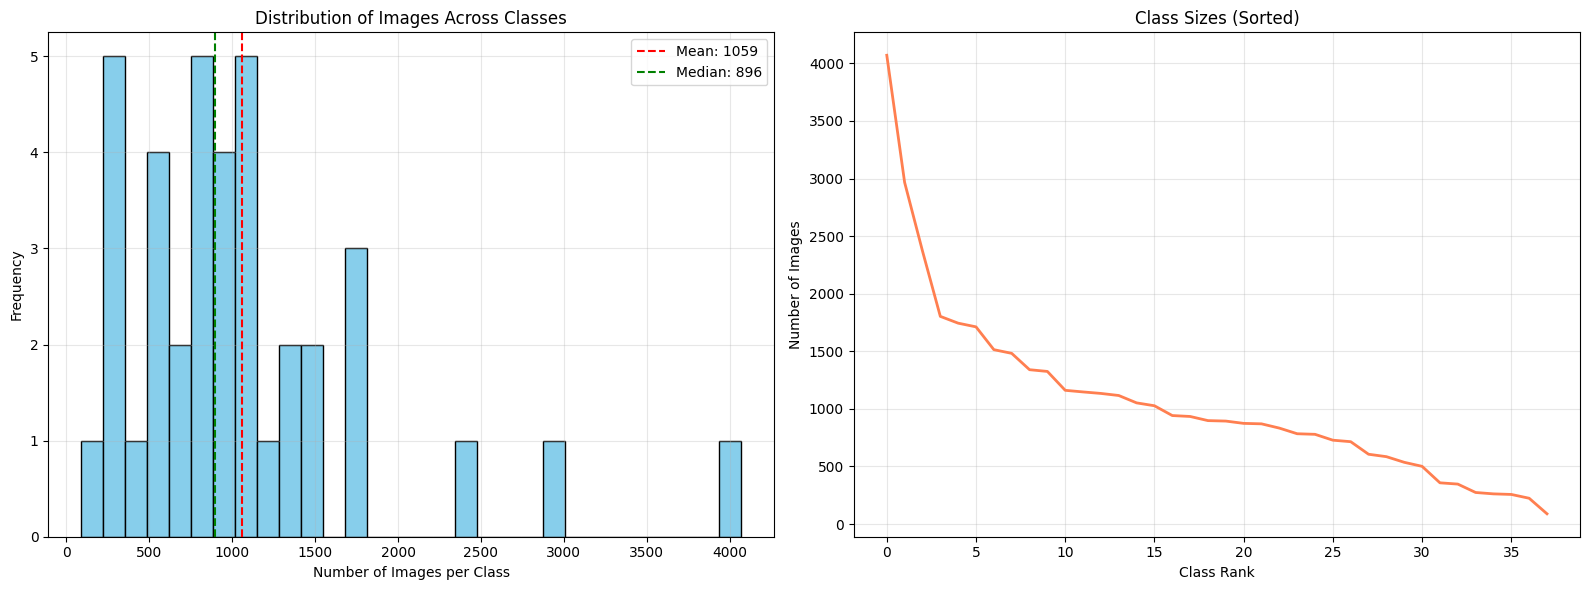


📝 Imbalance analysis saved to: /kaggle/working/MobilePlantViT/class_imbalance_analysis.json
✅ Class imbalance analysis complete!


In [7]:
# New Cell: Class Imbalance Analysis

print_section("CLASS IMBALANCE ANALYSIS")

# Count images per class in master directory
_, master_class_distribution = count_images_in_dir(master_directory_path)

# Calculate statistics
class_counts = list(master_class_distribution.values())
total_images = sum(class_counts)
mean_count = np.mean(class_counts)
median_count = np.median(class_counts)
std_count = np.std(class_counts)
min_count = min(class_counts)
max_count = max(class_counts)

# Calculate imbalance ratio
imbalance_ratio = max_count / min_count

print(f"📊 Class Distribution Statistics:")
print(f"   Total Classes:     {len(master_class_distribution)}")
print(f"   Total Images:      {total_images:,}")
print(f"   Mean per Class:    {mean_count:.1f}")
print(f"   Median per Class:  {median_count:.1f}")
print(f"   Std Dev:           {std_count:.1f}")
print(f"   Min Count:         {min_count}")
print(f"   Max Count:         {max_count}")
print(f"   Imbalance Ratio:   {imbalance_ratio:.2f}x")

# Classify imbalance severity
if imbalance_ratio <= 1.5:
    severity = "✅ BALANCED"
    recommendation = "No balancing needed"
elif imbalance_ratio <= 3:
    severity = "⚠️  SLIGHT IMBALANCE"
    recommendation = "Consider weighted loss or class weights"
elif imbalance_ratio <= 10:
    severity = "🔶 MODERATE IMBALANCE"
    recommendation = "Use weighted sampling or oversampling"
else:
    severity = "❌ SEVERE IMBALANCE"
    recommendation = "Use SMOTE, oversampling, or combined strategies"

print(f"\n{severity}")
print(f"   Recommendation: {recommendation}")

# Show top 10 largest and smallest classes
sorted_classes = sorted(master_class_distribution.items(), key=lambda x: x[1], reverse=True)

print(f"\n📈 Largest Classes (Top 10):")
print("-" * 80)
print(f"{'Class Name':<50} {'Count':<10} {'% of Total':<12}")
print("-" * 80)
for class_name, count in sorted_classes[:10]:
    percentage = (count / total_images) * 100
    print(f"{class_name:<50} {count:<10} {percentage:>6.2f}%")

print(f"\n📉 Smallest Classes (Bottom 10):")
print("-" * 80)
print(f"{'Class Name':<50} {'Count':<10} {'% of Total':<12}")
print("-" * 80)
for class_name, count in sorted_classes[-10:]:
    percentage = (count / total_images) * 100
    print(f"{class_name:<50} {count:<10} {percentage:>6.2f}%")

# Visualize distribution
plt.figure(figsize=(16, 6))

# Plot 1: Histogram of class sizes
plt.subplot(1, 2, 1)
plt.hist(class_counts, bins=30, color='skyblue', edgecolor='black')
plt.axvline(mean_count, color='red', linestyle='--', label=f'Mean: {mean_count:.0f}')
plt.axvline(median_count, color='green', linestyle='--', label=f'Median: {median_count:.0f}')
plt.xlabel('Number of Images per Class')
plt.ylabel('Frequency')
plt.title('Distribution of Images Across Classes')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Sorted class sizes
plt.subplot(1, 2, 2)
sorted_counts = sorted(class_counts, reverse=True)
plt.plot(sorted_counts, color='coral', linewidth=2)
plt.xlabel('Class Rank')
plt.ylabel('Number of Images')
plt.title('Class Sizes (Sorted)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save imbalance report
imbalance_report = {
    'total_classes': len(master_class_distribution),
    'total_images': total_images,
    'statistics': {
        'mean': float(mean_count),
        'median': float(median_count),
        'std': float(std_count),
        'min': int(min_count),
        'max': int(max_count),
        'imbalance_ratio': float(imbalance_ratio)
    },
    'severity': severity,
    'recommendation': recommendation,
    'class_distribution': master_class_distribution
}

imbalance_log_path = os.path.join(working_base, 'class_imbalance_analysis.json')
with open(imbalance_log_path, 'w') as f:
    json.dump(imbalance_report, f, indent=4)

print(f"\n📝 Imbalance analysis saved to: {imbalance_log_path}")
print("✅ Class imbalance analysis complete!")

**# CELL 8: Create Split Directories**

In [8]:
print_section("SPLIT DIRECTORY CREATION")

# Create main split directories
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Create class folders in each split
for class_name in CLASS_NAMES:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

print(f"✅ Split directories created")
print(f"   Train: {train_dir}")
print(f"   Val:   {val_dir}")
print(f"   Test:  {test_dir}")



  SPLIT DIRECTORY CREATION
✅ Split directories created
   Train: /kaggle/working/MobilePlantViT/data/PlantVillage_Split/train
   Val:   /kaggle/working/MobilePlantViT/data/PlantVillage_Split/val
   Test:  /kaggle/working/MobilePlantViT/data/PlantVillage_Split/test


**# CELL 9: Split Dataset into Train/Val/Test**

In [9]:
# CELL 6 (ENHANCED): Split Dataset with Balancing Options

print_section("SPLITTING DATASET WITH BALANCING (70/15/15)")

# ============================================================================
# CONFIGURATION: Choose your balancing strategy
# ============================================================================
BALANCING_STRATEGY = 'weighted_sampling'  # Options: 'none', 'weighted_sampling', 'oversample_minority', 'undersample_majority'

# Threshold for considering a class as minority (e.g., < 80% of median)
MINORITY_THRESHOLD = 0.8

# ============================================================================

split_stats = {
    'total_images': 0,
    'train_images': 0,
    'val_images': 0,
    'test_images': 0,
    'class_distribution': {},
    'minority_classes': [],
    'majority_classes': []
}

# Identify minority and majority classes
_, master_dist = count_images_in_dir(master_directory_path)
median_count = np.median(list(master_dist.values()))
minority_threshold_count = median_count * MINORITY_THRESHOLD

for class_name in CLASS_NAMES:
    count = master_dist[class_name]
    split_stats['class_distribution'][class_name] = {
        'total': count,
        'train': 0,
        'val': 0,
        'test': 0
    }
    
    if count < minority_threshold_count:
        split_stats['minority_classes'].append(class_name)
    else:
        split_stats['majority_classes'].append(class_name)

print(f"📊 Class Analysis:")
print(f"   Minority Classes ({len(split_stats['minority_classes'])}): < {minority_threshold_count:.0f} images")
print(f"   Majority Classes ({len(split_stats['majority_classes'])}): >= {minority_threshold_count:.0f} images")
print(f"   Strategy: {BALANCING_STRATEGY}")

# Perform splitting
if BALANCING_STRATEGY == 'oversample_minority':
    # Strategy 1: Oversample minority classes to match median
    print("\n🔄 Applying oversampling to minority classes...")
    
    for class_name in tqdm(CLASS_NAMES, desc="Splitting with oversampling"):
        class_source_path = os.path.join(master_directory_path, class_name)
        images = sorted([f for f in os.listdir(class_source_path)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        
        # Determine if oversampling is needed
        is_minority = class_name in split_stats['minority_classes']
        
        if is_minority:
            # Oversample to median count
            target_count = int(median_count)
            if len(images) < target_count:
                # Replicate images to reach target
                multiplier = int(np.ceil(target_count / len(images)))
                images = images * multiplier
                images = images[:target_count]
        
        # Shuffle
        random.shuffle(images)
        
        # Calculate split indices
        total = len(images)
        train_count = int(total * SPLIT_RATIO['train'])
        val_count = int(total * SPLIT_RATIO['val'])
        
        # Split
        train_imgs = images[:train_count]
        val_imgs = images[train_count:train_count + val_count]
        test_imgs = images[train_count + val_count:]
        
        # Copy to respective directories
        for img in train_imgs:
            src = os.path.join(class_source_path, img)
            dst = os.path.join(train_dir, class_name, img)
            
            # Handle duplicates from oversampling
            if os.path.exists(dst):
                base, ext = os.path.splitext(img)
                counter = 1
                while os.path.exists(dst):
                    new_name = f"{base}_dup{counter}{ext}"
                    dst = os.path.join(train_dir, class_name, new_name)
                    counter += 1
            
            shutil.copy2(src, dst)
        
        for img in val_imgs:
            shutil.copy2(os.path.join(class_source_path, img),
                        os.path.join(val_dir, class_name, img))
        for img in test_imgs:
            shutil.copy2(os.path.join(class_source_path, img),
                        os.path.join(test_dir, class_name, img))
        
        # Update stats
        split_stats['total_images'] += total
        split_stats['train_images'] += len(train_imgs)
        split_stats['val_images'] += len(val_imgs)
        split_stats['test_images'] += len(test_imgs)
        
        split_stats['class_distribution'][class_name]['train'] = len(train_imgs)
        split_stats['class_distribution'][class_name]['val'] = len(val_imgs)
        split_stats['class_distribution'][class_name]['test'] = len(test_imgs)

elif BALANCING_STRATEGY == 'undersample_majority':
    # Strategy 2: Undersample majority classes to match median
    print("\n🔄 Applying undersampling to majority classes...")
    
    for class_name in tqdm(CLASS_NAMES, desc="Splitting with undersampling"):
        class_source_path = os.path.join(master_directory_path, class_name)
        images = sorted([f for f in os.listdir(class_source_path)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        
        # Determine if undersampling is needed
        is_majority = class_name in split_stats['majority_classes']
        
        if is_majority:
            # Undersample to median count
            target_count = int(median_count)
            if len(images) > target_count:
                # Randomly sample target_count images
                random.shuffle(images)
                images = images[:target_count]
        
        # Shuffle
        random.shuffle(images)
        
        # Calculate split indices
        total = len(images)
        train_count = int(total * SPLIT_RATIO['train'])
        val_count = int(total * SPLIT_RATIO['val'])
        
        # Split
        train_imgs = images[:train_count]
        val_imgs = images[train_count:train_count + val_count]
        test_imgs = images[train_count + val_count:]
        
        # Copy to respective directories
        for img in train_imgs:
            shutil.copy2(os.path.join(class_source_path, img),
                        os.path.join(train_dir, class_name, img))
        for img in val_imgs:
            shutil.copy2(os.path.join(class_source_path, img),
                        os.path.join(val_dir, class_name, img))
        for img in test_imgs:
            shutil.copy2(os.path.join(class_source_path, img),
                        os.path.join(test_dir, class_name, img))
        
        # Update stats
        split_stats['total_images'] += total
        split_stats['train_images'] += len(train_imgs)
        split_stats['val_images'] += len(val_imgs)
        split_stats['test_images'] += len(test_imgs)
        
        split_stats['class_distribution'][class_name]['train'] = len(train_imgs)
        split_stats['class_distribution'][class_name]['val'] = len(val_imgs)
        split_stats['class_distribution'][class_name]['test'] = len(test_imgs)

else:
    # Strategy 3: Standard split (no balancing) or weighted_sampling (handled in dataloader)
    print("\n🔄 Performing standard split...")
    
    for class_name in tqdm(CLASS_NAMES, desc="Splitting"):
        class_source_path = os.path.join(master_directory_path, class_name)
        
        # Get all images
        images = sorted([f for f in os.listdir(class_source_path)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        
        # Shuffle
        random.shuffle(images)
        
        # Calculate split indices
        total = len(images)
        train_count = int(total * SPLIT_RATIO['train'])
        val_count = int(total * SPLIT_RATIO['val'])
        
        # Split
        train_imgs = images[:train_count]
        val_imgs = images[train_count:train_count + val_count]
        test_imgs = images[train_count + val_count:]
        
        # Copy to respective directories
        for img in train_imgs:
            shutil.copy2(os.path.join(class_source_path, img),
                        os.path.join(train_dir, class_name, img))
        for img in val_imgs:
            shutil.copy2(os.path.join(class_source_path, img),
                        os.path.join(val_dir, class_name, img))
        for img in test_imgs:
            shutil.copy2(os.path.join(class_source_path, img),
                        os.path.join(test_dir, class_name, img))
        
        # Update stats
        split_stats['total_images'] += total
        split_stats['train_images'] += len(train_imgs)
        split_stats['val_images'] += len(val_imgs)
        split_stats['test_images'] += len(test_imgs)
        
        split_stats['class_distribution'][class_name]['train'] = len(train_imgs)
        split_stats['class_distribution'][class_name]['val'] = len(val_imgs)
        split_stats['class_distribution'][class_name]['test'] = len(test_imgs)

print(f"\n✅ Dataset split complete")
print(f"   Total:  {split_stats['total_images']:,}")
print(f"   Train:  {split_stats['train_images']:,} ({split_stats['train_images']/split_stats['total_images']*100:.1f}%)")
print(f"   Val:    {split_stats['val_images']:,} ({split_stats['val_images']/split_stats['total_images']*100:.1f}%)")
print(f"   Test:   {split_stats['test_images']:,} ({split_stats['test_images']/split_stats['total_images']*100:.1f}%)")

# Analyze balance after splitting
train_counts = [stats['train'] for stats in split_stats['class_distribution'].values()]
new_imbalance_ratio = max(train_counts) / min(train_counts)

print(f"\n📊 Training Set Balance:")
print(f"   Before Strategy: {imbalance_ratio:.2f}x")
print(f"   After Strategy:  {new_imbalance_ratio:.2f}x")
if new_imbalance_ratio < imbalance_ratio:
    improvement = ((imbalance_ratio - new_imbalance_ratio) / imbalance_ratio) * 100
    print(f"   ✅ Improvement: {improvement:.1f}%")


  SPLITTING DATASET WITH BALANCING (70/15/15)
📊 Class Analysis:
   Minority Classes (12): < 717 images
   Majority Classes (26): >= 717 images
   Strategy: weighted_sampling

🔄 Performing standard split...


Splitting:   0%|          | 0/38 [00:00<?, ?it/s]


✅ Dataset split complete
   Total:  40,254
   Train:  28,157 (69.9%)
   Val:    6,022 (15.0%)
   Test:   6,075 (15.1%)

📊 Training Set Balance:
   Before Strategy: 45.73x
   After Strategy:  45.95x


**# CELL 10: Save Dataset Metadata & Create Kaggle Dataset**

In [11]:
# CELL: SAVE DATASET FOR KAGGLE

print_section("SAVING DATASET FOR KAGGLE REUSE")

import json

# ============================================================================
# 1. Save all metadata needed for training
# ============================================================================
if 'imbalance_ratio' not in globals():
    train_counts_check = [stats['train'] for stats in split_stats['class_distribution'].values()]
    imbalance_ratio = max(train_counts_check) / min(train_counts_check) if min(train_counts_check) > 0 else float('inf')
    
if 'new_imbalance_ratio' not in globals():
    train_counts = [stats['train'] for stats in split_stats['class_distribution'].values()]
    new_imbalance_ratio = max(train_counts) / min(train_counts) if min(train_counts) > 0 else float('inf')


dataset_metadata = {
    'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'random_seed': RANDOM_SEED,
    
    # Dataset info
    'num_classes': NUM_CLASSES,
    'class_names': CLASS_NAMES,
    
    # Split statistics
    'split_ratio': SPLIT_RATIO,
    'split_stats': split_stats,
    
    # Balancing info
    'balancing_strategy': BALANCING_STRATEGY,
    'imbalance_ratio_original': float(imbalance_ratio),
    'imbalance_ratio_after_split': float(new_imbalance_ratio),
    
    # Normalization values (important for training)
    'imagenet_mean': IMAGENET_MEAN,
    'imagenet_std': IMAGENET_STD,
    
    # Directory structure
    'directory_structure': {
        'train': 'train',
        'val': 'val', 
        'test': 'test'
    },
    
    # Class distribution for weighted loss
    'train_class_distribution': {cls: stats['train'] for cls, stats in split_stats['class_distribution'].items()},
    'val_class_distribution': {cls: stats['val'] for cls, stats in split_stats['class_distribution'].items()},
    'test_class_distribution': {cls: stats['test'] for cls, stats in split_stats['class_distribution'].items()}
}

# Save metadata JSON
metadata_path = os.path.join(split_directory_path, 'dataset_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(dataset_metadata, f, indent=4)

print(f"✅ Metadata saved to: {metadata_path}")

# ============================================================================
# 2. Verify the saved dataset structure
# ============================================================================

print("\n📁 Final Dataset Structure:")
print(f"   {split_directory_path}/")
print(f"   ├── train/          ({split_stats['train_images']:,} images)")
print(f"   ├── val/            ({split_stats['val_images']:,} images)")
print(f"   ├── test/           ({split_stats['test_images']:,} images)")
print(f"   └── dataset_metadata.json")

# Verify counts match
train_verify, _ = count_images_in_dir(train_dir)
val_verify, _ = count_images_in_dir(val_dir)
test_verify, _ = count_images_in_dir(test_dir)

print(f"\n🔍 Verification:")
print(f"   Train: {train_verify:,} images ({'✅' if train_verify == split_stats['train_images'] else '❌'})")
print(f"   Val:   {val_verify:,} images ({'✅' if val_verify == split_stats['val_images'] else '❌'})")
print(f"   Test:  {test_verify:,} images ({'✅' if test_verify == split_stats['test_images'] else '❌'})")

# ============================================================================
# 3. Create zip for Kaggle dataset upload
# ============================================================================

print("\n" + "=" * 80)
print("  CREATING KAGGLE DATASET")
print("=" * 80)

import zipfile

# Create zip file of the split dataset
zip_path = '/kaggle/working/plantvillage_preprocessed.zip'

print("\n📦 Creating zip archive...")
print("   This may take several minutes for large datasets...")

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in tqdm(os.walk(split_directory_path), desc="Zipping"):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, split_directory_path)
            zipf.write(file_path, arcname)

# Get zip file size
zip_size_mb = os.path.getsize(zip_path) / (1024 * 1024)
print(f"\n✅ Zip archive created: {zip_path}")
print(f"   Size: {zip_size_mb:.2f} MB")

# ============================================================================
# 4. Instructions for uploading to Kaggle
# ============================================================================

print("\n" + "=" * 80)
print("  NEXT STEPS: UPLOAD TO KAGGLE DATASETS")
print("=" * 80)

instructions = """
📋 MANUAL STEPS TO CREATE KAGGLE DATASET:

1. DOWNLOAD THE ZIP FILE:
   - In Kaggle notebook, go to the Output tab (right panel)
   - Find 'plantvillage_preprocessed.zip'
   - Click the download button

2. CREATE NEW KAGGLE DATASET:
   - Go to: https://www.kaggle.com/datasets
   - Click '+ New Dataset'
   - Upload the zip file
   - Name it: 'plantvillage-preprocessed' (or your preferred name)
   - Set visibility (Private/Public)
   - Click 'Create'

3. WAIT FOR PROCESSING:
   - Kaggle will extract and process the zip
   - This may take a few minutes

4. USE IN TRAINING NOTEBOOK:
   - Add the dataset to your training notebook
   - The path will be: /kaggle/input/plantvillage-preprocessed/

⚠️  IMPORTANT: The dataset_metadata.json file contains all settings
    needed to recreate the exact same preprocessing configuration.
"""

print(instructions)

# Also save instructions to a file
with open('/kaggle/working/upload_instructions.txt', 'w') as f:
    f.write(instructions)

print("✅ Preprocessing complete! Dataset ready for upload.")


  SAVING DATASET FOR KAGGLE REUSE
✅ Metadata saved to: /kaggle/working/MobilePlantViT/data/PlantVillage_Split/dataset_metadata.json

📁 Final Dataset Structure:
   /kaggle/working/MobilePlantViT/data/PlantVillage_Split/
   ├── train/          (28,157 images)
   ├── val/            (6,022 images)
   ├── test/           (6,075 images)
   └── dataset_metadata.json

🔍 Verification:
   Train: 28,157 images (✅)
   Val:   6,022 images (✅)
   Test:  6,075 images (✅)

  CREATING KAGGLE DATASET

📦 Creating zip archive...
   This may take several minutes for large datasets...


Zipping: 0it [00:00, ?it/s]


✅ Zip archive created: /kaggle/working/plantvillage_preprocessed.zip
   Size: 363.32 MB

  NEXT STEPS: UPLOAD TO KAGGLE DATASETS

📋 MANUAL STEPS TO CREATE KAGGLE DATASET:

1. DOWNLOAD THE ZIP FILE:
   - In Kaggle notebook, go to the Output tab (right panel)
   - Find 'plantvillage_preprocessed.zip'
   - Click the download button

2. CREATE NEW KAGGLE DATASET:
   - Go to: https://www.kaggle.com/datasets
   - Click '+ New Dataset'
   - Upload the zip file
   - Name it: 'plantvillage-preprocessed' (or your preferred name)
   - Set visibility (Private/Public)
   - Click 'Create'

3. WAIT FOR PROCESSING:
   - Kaggle will extract and process the zip
   - This may take a few minutes

4. USE IN TRAINING NOTEBOOK:
   - Add the dataset to your training notebook
   - The path will be: /kaggle/input/plantvillage-preprocessed/

⚠️  IMPORTANT: The dataset_metadata.json file contains all settings
    needed to recreate the exact same preprocessing configuration.

✅ Preprocessing complete! Dataset re